# Tutorial 1 - Intro to neural ODE based Neural Networks
The goal of this tutorial is to get familiar with the fundamentals of the code basis and ensure it is running  
The notebook utilizes code from the package torchdiffeq and Borjan Geshkovski https://github.com/borjanG/2021-dynamical-systems

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt



# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

Data point of X: [0.6051291  0.78405649] 
Data type X: float64

Data point of y: 0 
Data type y: float64


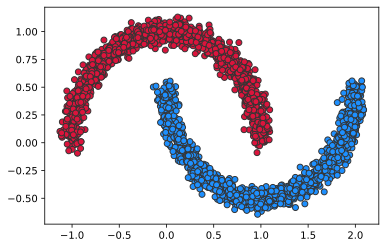

In [2]:
#We load a typical toy dataset that requires a nonlinear classification model to achieve high accuracy
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

#the noise describes how large the standard deviation of the data distribution is
noise = 0.05

#Load 3000 instances of data points

X, y = make_moons(n_samples = 3000, noise = noise)

#alternative toy data set
# X, y = make_circles(3000, noise=noise, factor=0.15)


print('Data point of X:', X[0], '\nData type X:', X.dtype)
print('\nData point of y:', y[0], '\nData type y:', X.dtype)

#Visualizing the data
data_0 = X[y == 0]
data_1 = X[y == 1]
fig = plt.figure()
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", color = 'crimson')
plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", color = 'dodgerblue')
plt.show()

As typical for machine learning algorithms, we split the data into a training set and test set.  
To use the pytorch frameset, we recast the data as tensors and create Dataloaders used to conveniently load the training and test data during training and validation.

In [3]:
from torch.utils.data import DataLoader,TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2 )

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64, shuffle = False)
dataloader_viz = DataLoader(test, batch_size=128, shuffle = False)

In [4]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 0.1540, -0.1450],
        [ 0.7407, -0.4849],
        [ 1.4931, -0.4632],
        [ 0.3291, -0.3785],
        [ 0.9820,  0.2499],
        [ 0.2620,  0.8864],
        [ 0.3930, -0.3470],
        [ 0.1869,  1.0157],
        [-0.9538,  0.3843],
        [ 0.7970,  0.5632]]) tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0])


# Model dynamics

In [5]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5.0, 6 
dt = T/num_steps
bound = 0.
fp = False
cross_entropy = True


non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside

v_steps = 5
training = True #train new network or load saved one


torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)


NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [6]:
from models.training import Trainer

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                         bound=bound, fixed_projector=fp, verbose = True) 

trainer_anode.train(dataloader, num_epochs)

c:\Users\Tobias\FAUbox\Python (merge)\borjan dynamical.systems\models\training.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)



Epoch 0/38
Loss: 0.859
Accuracy: 0.500

Epoch 10/38
Loss: 0.836
Accuracy: 0.500

Epoch 20/38
Loss: 0.810
Accuracy: 0.500

Epoch 30/38
Loss: 0.812
Accuracy: 0.531
Epoch 1: 0.824

Epoch 0/38
Loss: 0.753
Accuracy: 0.500

Epoch 10/38
Loss: 0.742
Accuracy: 0.500

Epoch 20/38
Loss: 0.720
Accuracy: 0.500

Epoch 30/38
Loss: 0.724
Accuracy: 0.500
Epoch 2: 0.731

Epoch 0/38
Loss: 0.674
Accuracy: 0.500

Epoch 10/38
Loss: 0.672
Accuracy: 0.578

Epoch 20/38
Loss: 0.649
Accuracy: 0.703

Epoch 30/38
Loss: 0.652
Accuracy: 0.766
Epoch 3: 0.657

Epoch 0/38
Loss: 0.611
Accuracy: 0.844

Epoch 10/38
Loss: 0.616
Accuracy: 0.766

Epoch 20/38
Loss: 0.587
Accuracy: 0.828

Epoch 30/38
Loss: 0.588
Accuracy: 0.797
Epoch 4: 0.594

Epoch 0/38
Loss: 0.555
Accuracy: 0.906

Epoch 10/38
Loss: 0.568
Accuracy: 0.812

Epoch 20/38
Loss: 0.531
Accuracy: 0.875

Epoch 30/38
Loss: 0.529
Accuracy: 0.828
Epoch 5: 0.536

Epoch 0/38
Loss: 0.503
Accuracy: 0.859

Epoch 10/38
Loss: 0.524
Accuracy: 0.812

Epoch 20/38
Loss: 0.475
Accu

## Generate a gif of the evolution of the input points through the neural network

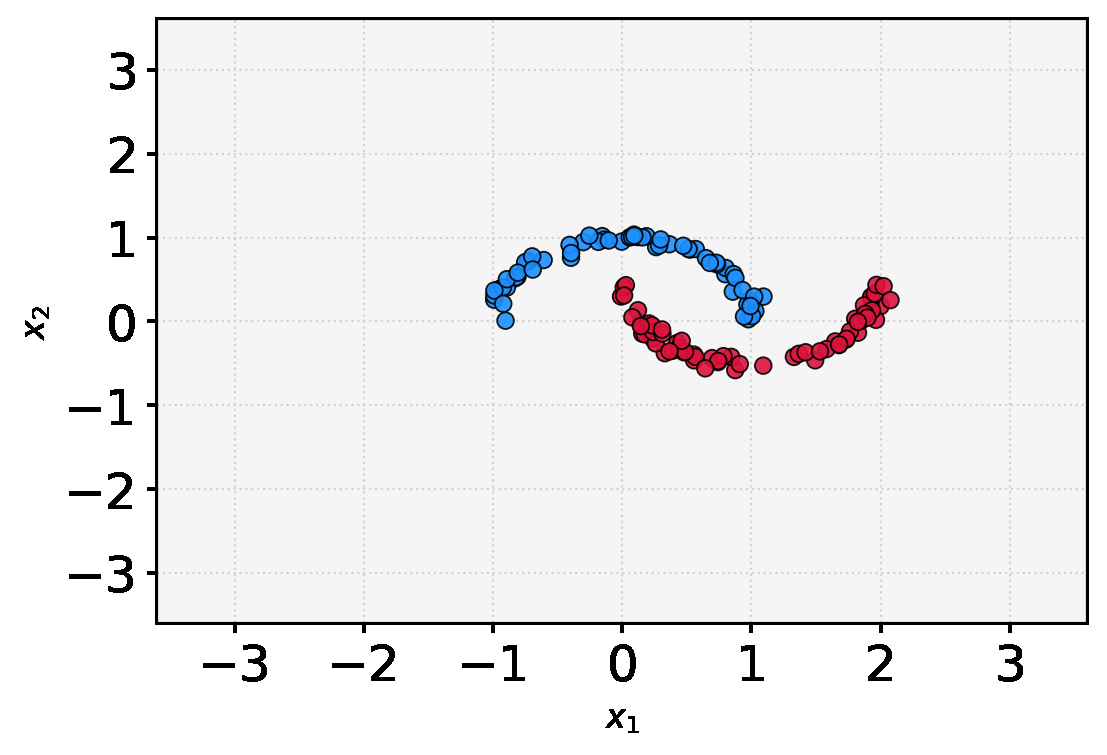

In [7]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory.gif", retina = True)

Observe that the blue and red data points are getting seperated further as time passes.

In [8]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)

rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [9]:
from models.training import doublebackTrainer

#here trainer_anode

trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, 
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0.1)

trainer_rnode.train(dataloader, num_epochs)


Epoch 0/38
Loss: 0.859
Accuracy: 0.500

Epoch 10/38
Loss: 0.836
Accuracy: 0.500

Epoch 20/38
Loss: 0.810
Accuracy: 0.500

Epoch 30/38
Loss: 0.812
Accuracy: 0.531
Epoch 1: 0.824

Epoch 0/38
Loss: 0.753
Accuracy: 0.500

Epoch 10/38
Loss: 0.742
Accuracy: 0.500

Epoch 20/38
Loss: 0.720
Accuracy: 0.500

Epoch 30/38
Loss: 0.724
Accuracy: 0.500
Epoch 2: 0.731

Epoch 0/38
Loss: 0.674
Accuracy: 0.500

Epoch 10/38
Loss: 0.672
Accuracy: 0.578

Epoch 20/38
Loss: 0.649
Accuracy: 0.703

Epoch 30/38
Loss: 0.652
Accuracy: 0.766
Epoch 3: 0.657

Epoch 0/38
Loss: 0.611
Accuracy: 0.844

Epoch 10/38
Loss: 0.616
Accuracy: 0.766

Epoch 20/38
Loss: 0.587
Accuracy: 0.828

Epoch 30/38
Loss: 0.588
Accuracy: 0.797
Epoch 4: 0.594

Epoch 0/38
Loss: 0.555
Accuracy: 0.906

Epoch 10/38
Loss: 0.568
Accuracy: 0.812

Epoch 20/38
Loss: 0.531
Accuracy: 0.875

Epoch 30/38
Loss: 0.529
Accuracy: 0.828
Epoch 5: 0.536

Epoch 0/38
Loss: 0.503
Accuracy: 0.859

Epoch 10/38
Loss: 0.524
Accuracy: 0.812

Epoch 20/38
Loss: 0.475
Accu

In [10]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(rnode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif')
    break

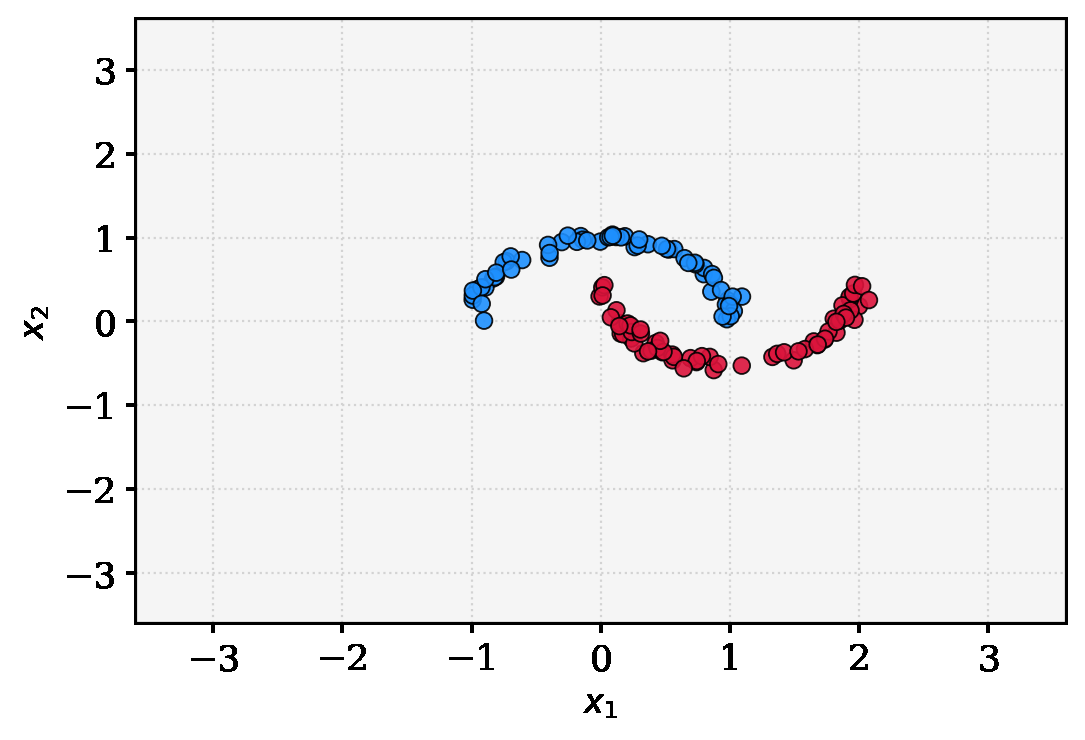

In [11]:
#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory_db.gif", retina = True)

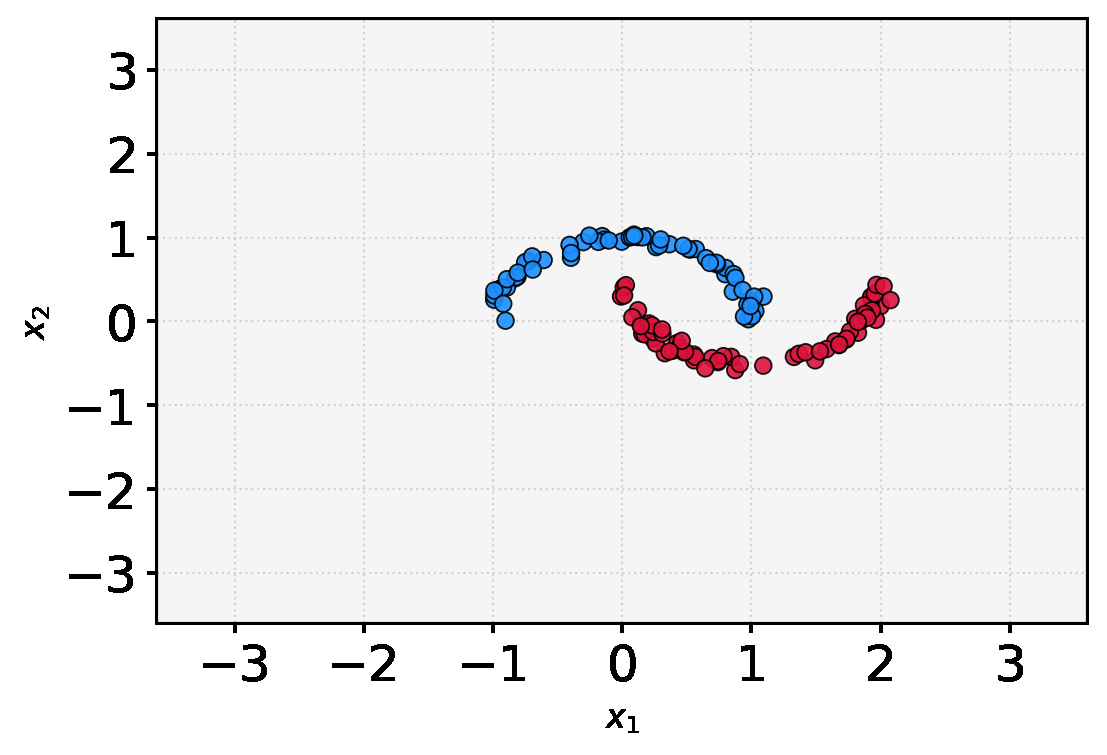

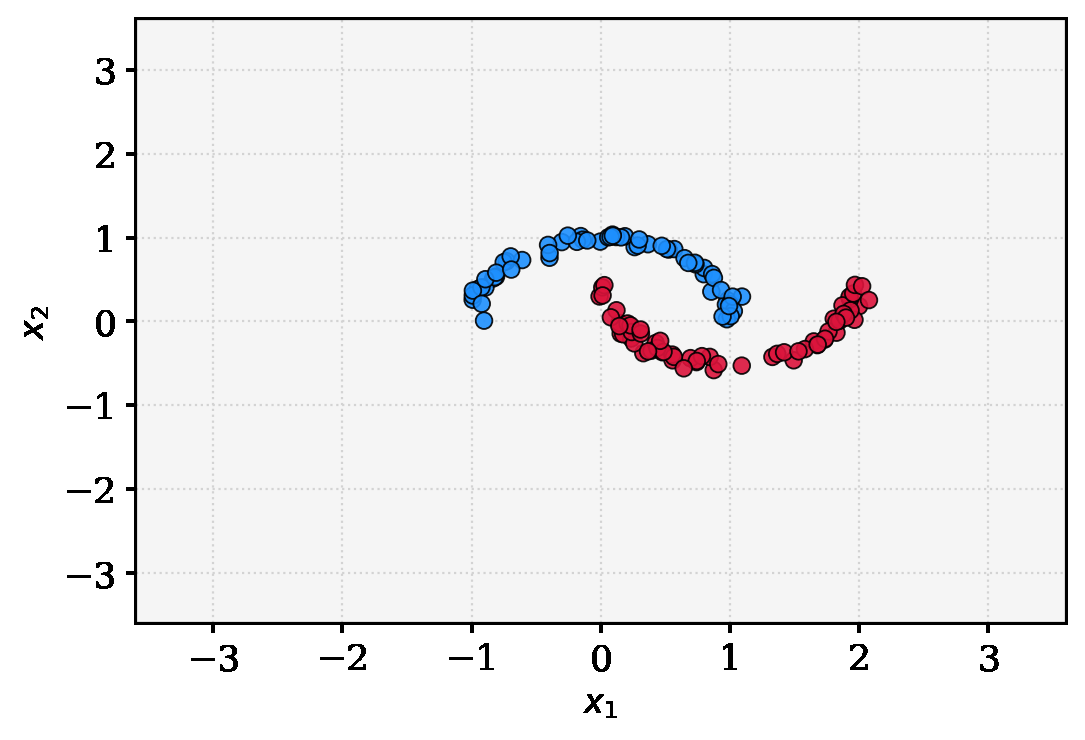

In [12]:
#Display of the generated gif

from IPython.display import Image
traj = Image(filename="trajectory.gif", retina = True)
rtraj = Image(filename="trajectory_db.gif", retina = True)
display(traj, rtraj)


In [15]:
import seaborn as sns
from matplotlib.colors import to_rgba, to_rgb
import numpy as np
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

@torch.no_grad()
def visualize_classification(model, data, label, grad = None, fig_name=None, footnote=None, contour = True, x1lims = [-2, 2], x2lims = [-2, 2]):
    
    
    x1lower, x1upper = x1lims
    x2lower, x2upper = x2lims

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(5, 5), dpi=300)
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0", zorder = 1)
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1", zorder = 1)

    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)
    # plt.legend()
    if grad is not None:
        for i in range(len(data[:, 0])):
            plt.arrow(data[i, 0], data[i, 1], grad[i, 0], grad[i, 1],
                    head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5)

   
    model.to(device)
    # creates the RGB values of the two scatter plot colors.
    # c0 = torch.Tensor(to_rgba("C0")).to(device)
    # c1 = torch.Tensor(to_rgba("C1")).to(device)

    

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds, _ = model(model_inputs)
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    # now we only want to have the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    # Specifying "None" in a dimension creates a new one. The rgb values hence get rescaled according to the prediction
    # output_image = (1 - preds) * c1[None, None] + preds * c0[None, None]
    # # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    # output_image = output_image.cpu().numpy()
    # plt.imshow(output_image, origin='lower', extent=(x1lower, x1upper, x2lower, x2upper), zorder = -1)
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])
    # plt.axis('scaled')

    # labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.numpy()]
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is black, last is red
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        plt.contourf(xx1, xx2, z, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        



    # preds_contour = preds.view(len(x1), len(x1)).detach()
    # plt.contourf(xx1, xx2, preds_contour, alpha=1)
    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
    return fig

c:\ProgramData\Anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


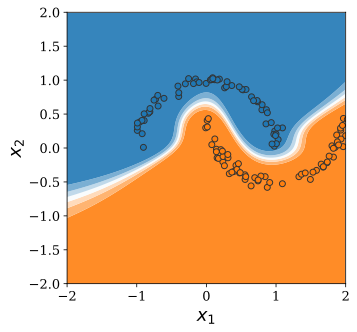

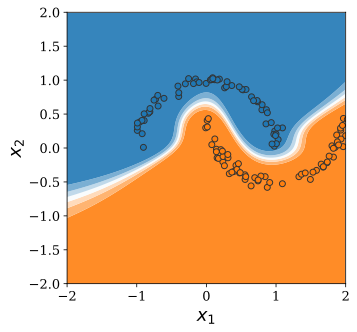

In [14]:
for X_viz, y_viz in dataloader_viz:
    visualize_classification(anode, X_viz, y_viz, fig_name = 'class_test')
    visualize_classification(rnode, X_viz, y_viz, fig_name = 'class_test')
    break